In [2]:
import pandas as pd

import requests
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
api_token = '3d1ba8b6773d47e3859ce59d0a992bc5'

stations = { # Selected by 
    'Downtown LA/USC' : 'KCQT',
    'LAX': 'KLAX',
    'Hawthorn': 'KHHR',
    'Van Nuys': 'KVNY',
    'Burbank': 'KBUR',
    'Whiteman': 'KWHP',
    'Santa Monica': 'KSMO',
    'Torence': 'KTOA',
    'Long Beach': 'KLGB',
    'El Monte': 'KEMT'
    }

startdate = '201801010000' # string in format of YYYMMDDHHmm
enddate = '202301010000'
vars_list = [ # not all stations have all variables, but full list available at: https://developers.synopticdata.com/about/station-variables/ 
    'air_temp', 
    'air_temp_high_24_hour' , 
    'relative_humidity'
    ]
pull_vars = ','.join(vars_list)

In [4]:
def heat_index(t:float, rh:float) -> float:
    """
    Calculate Heat Index or "Feels Like" temperature from air temperature and relative humidity

    Arguments:
        t: air temperature
        rh: relative humidity

    formula source: https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    """
    HI = 0.5*(t + 61 + ((t-68)*1.2) + (rh*0.094)) # general formula for days where the average between this and the air temp is less than 80

    if ((HI+t)/2) > 80:
        HI = (-42.379 + 
            2.04901523*t + 10.14333127*rh - 
            0.22475541*t*rh - 0.00683783*t*t - 0.05481717*rh*rh + 
            0.00122874*t**2*rh + .00085282*t*rh**2 - 
            .00000199*t**2*rh**2
        )
    # conditional adjustments 
        if rh < 13 and 80 < t < 112:
            HI = HI - (((13-rh)/4)* math.sqrt((17-abs(t-95))/17)) 
        elif rh > 85 and 80 < t < 87:
            HI = HI + (((rh-85)/10)*((87-t)/5))

    return HI

In [5]:
json_dict = {}
stid_df_list = []
for stid in stations.values():
    # api documentation is at: https://developers.synopticdata.com/mesonet/explorer/ 
    url = f'https://api.synopticdata.com/v2/stations/timeseries?&token={api_token}&start={startdate}&end={enddate}&stid={stid}&units=english&vars={pull_vars}'
    r = requests.get(url)
    json_dict[stid] = r.json()
    temp_df = pd.DataFrame.from_dict(json_dict[stid]['STATION'][0]['OBSERVATIONS'])
    temp_df['stid'] = stid
    stid_df_list.append(temp_df)
    

In [6]:
df = pd.concat(stid_df_list,ignore_index=True) # put dataframes together
df.date_time = pd.to_datetime(df.date_time)

df.head()

,date_time,relative_humidity_set_1,air_temp_high_24_hour_set_1,air_temp_set_1,stid
0,2018-01-01 00:47:00+00:00,77.52,NaN,59.00,KCQT
1,2018-01-01 01:47:00+00:00,83.23,NaN,57.02,KCQT
2,2018-01-01 02:47:00+00:00,90.04,NaN,55.94,KCQT
3,2018-01-01 03:11:00+00:00,90.04,NaN,55.94,KCQT
4,2018-01-01 03:47:00+00:00,89.41,NaN,55.04,KCQT


In [7]:
df.drop(columns=['air_temp_high_24_hour_set_1'], inplace=True) # not that useful for now at least
df.rename(
    columns={
        'relative_humidity_set_1': 'relative_humidity', 
        'air_temp_set_1': 'air_temp'
        },
    inplace=True
    )
df.head()

,date_time,relative_humidity,air_temp,stid
0,2018-01-01 00:47:00+00:00,77.52,59.00,KCQT
1,2018-01-01 01:47:00+00:00,83.23,57.02,KCQT
2,2018-01-01 02:47:00+00:00,90.04,55.94,KCQT
3,2018-01-01 03:11:00+00:00,90.04,55.94,KCQT
4,2018-01-01 03:47:00+00:00,89.41,55.04,KCQT


In [8]:
df['heat_index'] = np.vectorize(heat_index)(df['air_temp'], df['relative_humidity']) # calc heat index column
df.head()

,date_time,relative_humidity,air_temp,stid,heat_index
0,2018-01-01 00:47:00+00:00,77.52,59.00,KCQT,58.24344
1,2018-01-01 01:47:00+00:00,83.23,57.02,KCQT,56.33381
2,2018-01-01 02:47:00+00:00,90.04,55.94,KCQT,55.46588
3,2018-01-01 03:11:00+00:00,90.04,55.94,KCQT,55.46588
4,2018-01-01 03:47:00+00:00,89.41,55.04,KCQT,54.44627


In [9]:
df.sample(5) # spot check the calculations

,date_time,relative_humidity,air_temp,stid,heat_index
707112,2018-11-17 21:50:00+00:00,64.10,68.00,KHHR,67.51270
2043136,2020-12-09 21:55:00+00:00,16.46,75.20,KBUR,73.19362
1114344,2022-08-01 00:25:00+00:00,57.69,78.80,KHHR,79.09143
1997816,2020-06-18 16:40:00+00:00,77.33,62.60,KBUR,62.19451
2211211,2022-06-26 14:53:00+00:00,59.39,71.96,KBUR,71.64733


In [10]:
daily_high_df = df.groupby([df.date_time.dt.date, 'stid']).max() # find daily high
daily_high_df.drop(columns=['date_time'], inplace=True)
daily_high_df.reset_index(inplace=True)
daily_high_df['date_time'] = pd.to_datetime(daily_high_df['date_time'])
daily_high_df.head()

,date_time,stid,relative_humidity,air_temp,heat_index
0,2018-01-01,KBUR,100.00,73.94,72.12299
1,2018-01-01,KCQT,96.07,69.98,68.25156
2,2018-01-01,KEMT,82.14,71.60,69.71678
3,2018-01-01,KHHR,100.00,69.80,68.80321
4,2018-01-01,KLAX,100.00,66.20,65.52189


Text(0.02, 0.5, 'Heat Index (Degrees)')

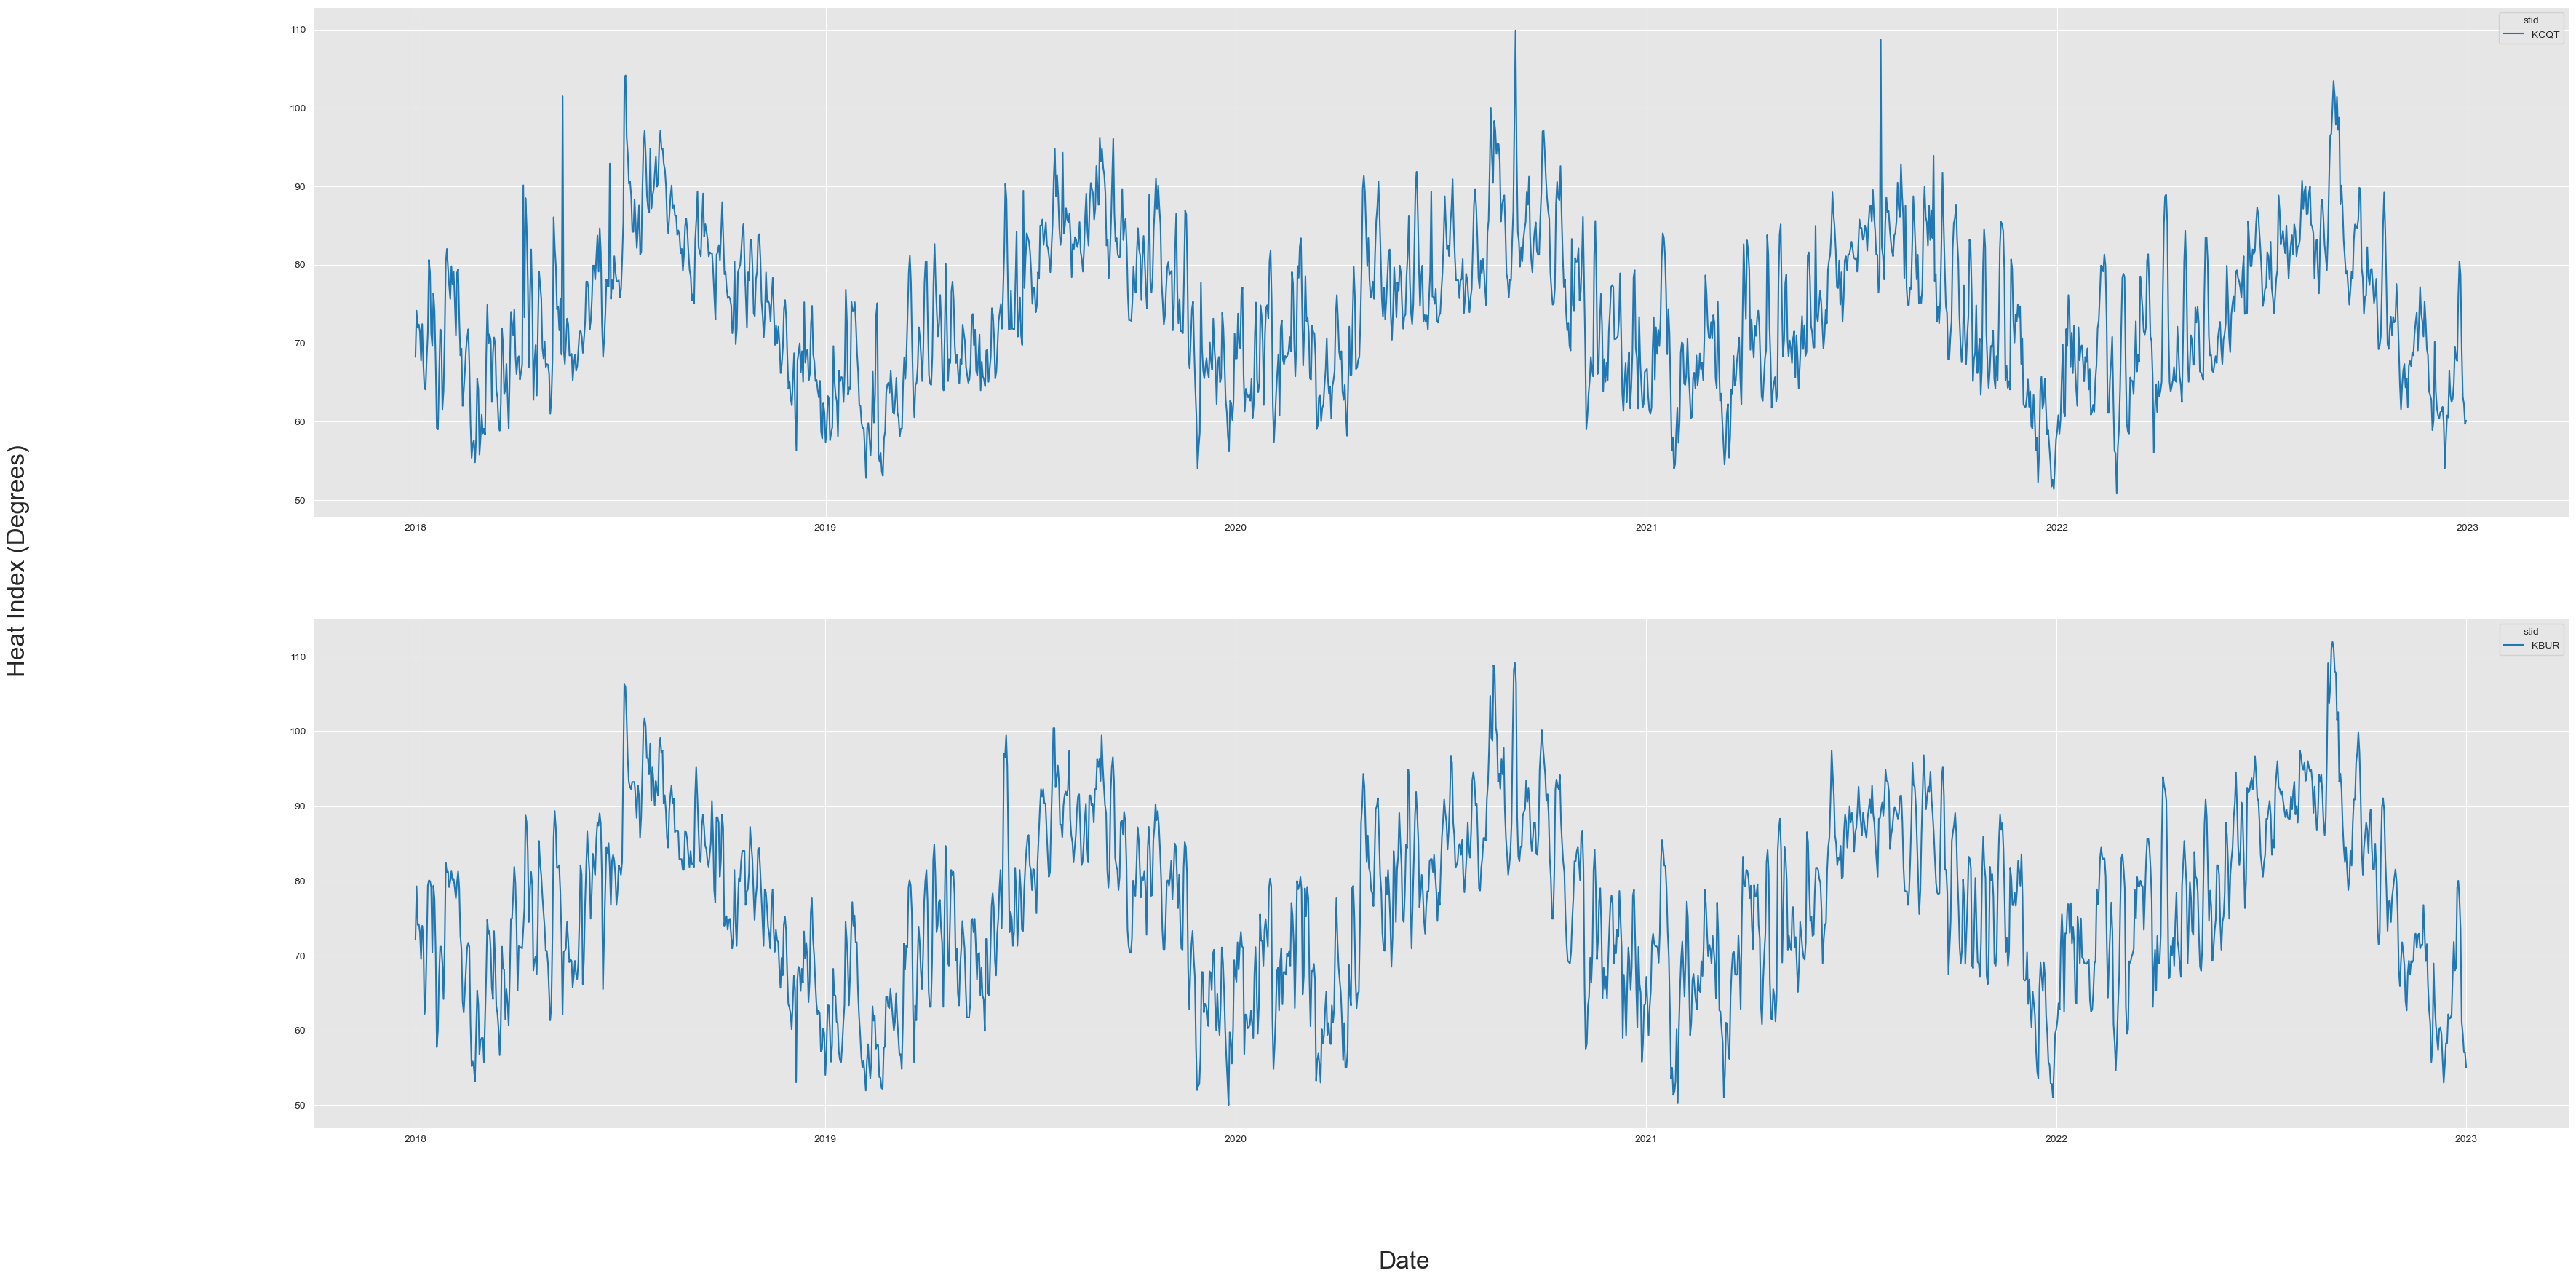

In [11]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(2, figsize=(40,20))

sns.lineplot(data=daily_high_df[daily_high_df['stid'].isin(['KCQT'])], x='date_time', y='heat_index', hue='stid', ax=ax[0])

sns.lineplot(data=daily_high_df[daily_high_df['stid'].isin(['KBUR'])], x='date_time', y='heat_index', hue='stid', ax=ax[1])

for plot in ax:
    plot.set(xlabel=None, ylabel=None)

fig.supxlabel('Date', fontsize=24)
fig.supylabel('Heat Index (Degrees)', fontsize=24)


In [12]:
above_90 = daily_high_df[daily_high_df['heat_index']>90].groupby([daily_high_df.date_time.dt.year,'stid']).count()
above_90 = above_90['heat_index'].reset_index()
above_90.rename(columns={'date_time': 'year', 'stid': 'station', 'heat_index': 'heat_days'}, inplace=True)
above_90.head()

,year,station,heat_days
0,2018,KBUR,43
1,2018,KCQT,23
2,2018,KEMT,47
3,2018,KHHR,9
4,2018,KLAX,7


In [13]:
station_places = {v: k for k, v in stations.items()}
above_90['place'] = above_90['station'].map(station_places)
above_90.head()

,year,station,heat_days,place
0,2018,KBUR,43,Burbank
1,2018,KCQT,23,Downtown LA/USC
2,2018,KEMT,47,El Monte
3,2018,KHHR,9,Hawthorn
4,2018,KLAX,7,LAX


In [23]:
colors = dict(zip(above_90.place.unique(), list(sns.color_palette().as_hex())))

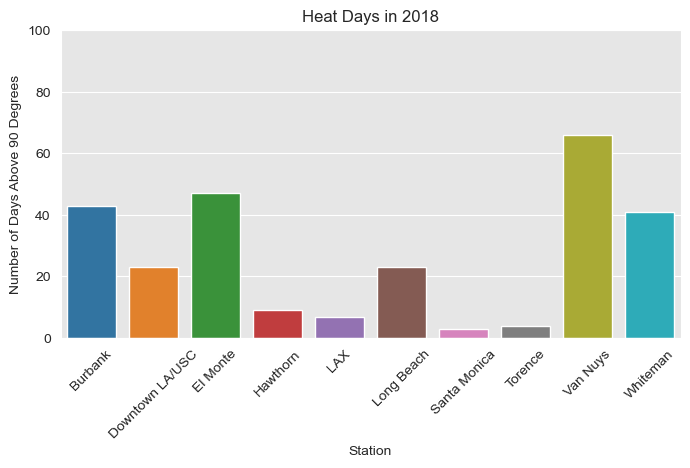

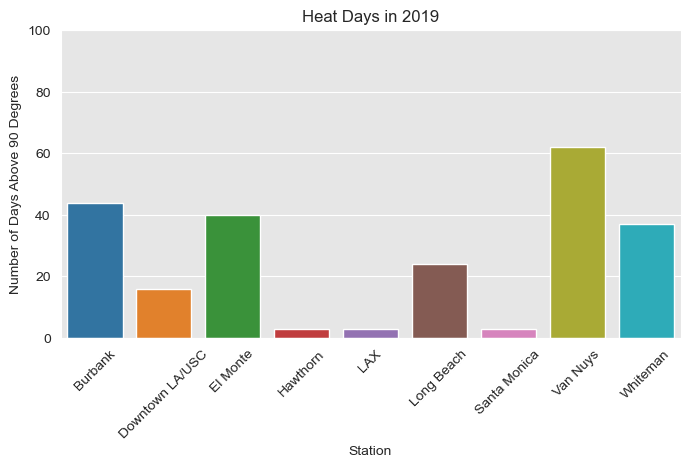

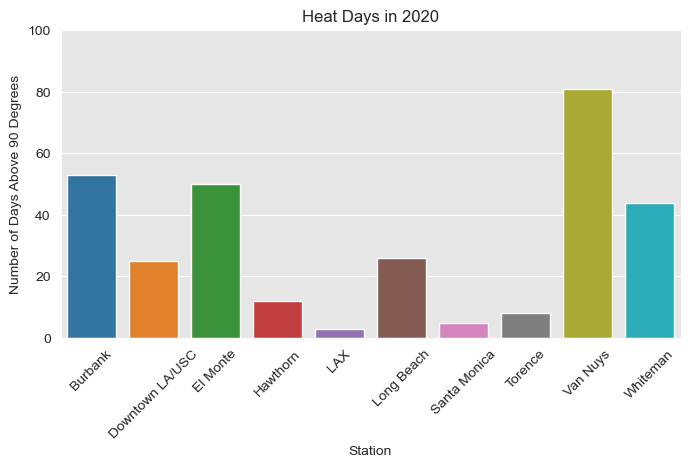

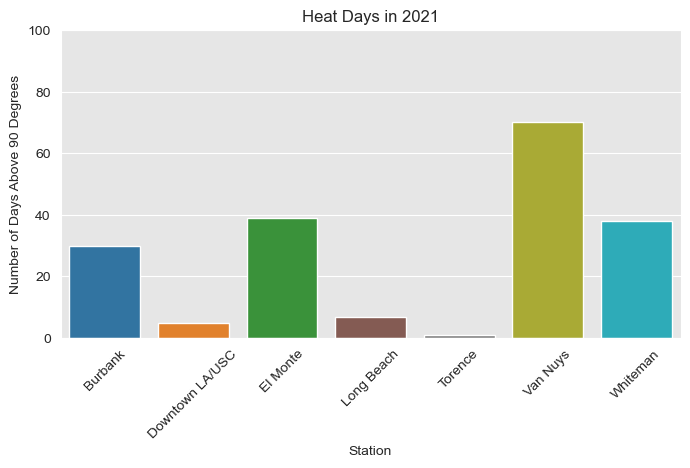

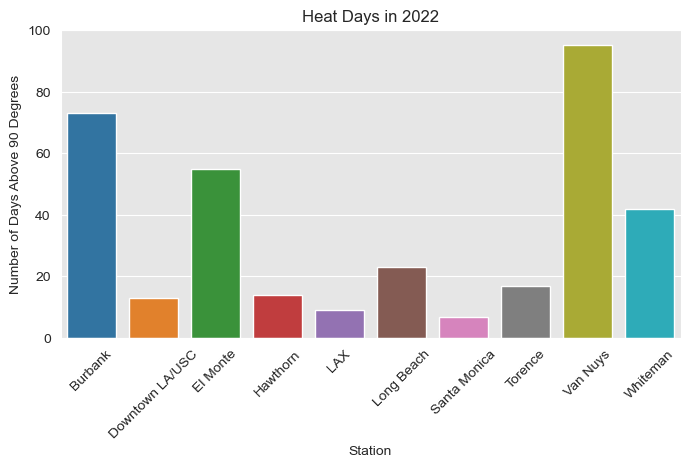

In [31]:
for year in above_90['year'].unique():
    fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(above_90[above_90['year']==year], 
                x='place', 
                y='heat_days', 
                palette=colors # keeps color mapping consistent across years
            )
    plt.ylim(top=100) # set consistent y axis scale
    plt.xlabel('Station')
    plt.ylabel('Number of Days Above 90 Degrees')
    plt.xticks(rotation=45)
    plt.title(f'Heat Days in {year}')